# 将模型预测的参数值可视化出来

## 导入所有信息

### 导入依赖

In [1]:
import json
import os
import sys
import pickle

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
sys.path.append(os.getenv("PROJ_PATH"))  # type: ignore

from dmg.core.post.plot_parameters import plot_parameters, plot_parameter_distributions  # noqa
from project.better_estimate import load_config  # noqa

### 导入配置

In [2]:
config = load_config(r"conf/config_dhbv_tsmixer.yaml")
out_path = config["out_path"]

### 加载数据

In [3]:
from dmg.core.data.loaders import HydroLoader   # noqa

loader = HydroLoader(config, test_split=True, overwrite=False)
loader.load_dataset()
eval_dataset = loader.eval_dataset

### 加载流域ids

In [4]:
with open(os.path.join(os.getenv("DATA_PATH"), "531sub_id.txt"), "r") as f:
    selected_basins = np.array(json.load(f))

## 构建模型

In [5]:
from dmg import ModelHandler
from dmg.core.utils import import_trainer  # noqa
config['mode'] = 'test'
config['test']['test_epoch'] = 45
model = ModelHandler(config, verbose=True)
trainer_cls = import_trainer(config['trainer'])
trainer = trainer_cls(
    config,
    model,
    eval_dataset=eval_dataset,
    verbose=True,
)
nn_model = trainer.model.model_dict['Hbv_2'].nn_model
tsmixesinv = nn_model.tsmixesinv
fc_layer = nn_model.fc

def predict(x):
    tcn_out = tsmixesinv(
        x.permute(1, 0, 2)
    )  # dim: timesteps, gages, params
    fc_out = fc_layer(tcn_out.permute(1, 0, 2))
    return fc_out

## 得到模型输出结果

In [6]:
import torch

model_input = eval_dataset["xc_nn_norm"]
# select_basin_idx = np.where(selected_basins==8023080)[0][0]
select_basin_idx = 0
print(select_basin_idx)
tmp_model_input = model_input[0:730, select_basin_idx : select_basin_idx + 2, :]
print(tmp_model_input.shape)
layer_output = predict(tmp_model_input)
print(layer_output.shape)
layer_output = torch.sigmoid(layer_output.reshape(-1, 2, 3, 16))[:,0,:,:]
# layer_output = layer_output[:, :, :]
print(layer_output.shape)

0
torch.Size([730, 2, 38])
torch.Size([730, 2, 48])
torch.Size([730, 3, 16])


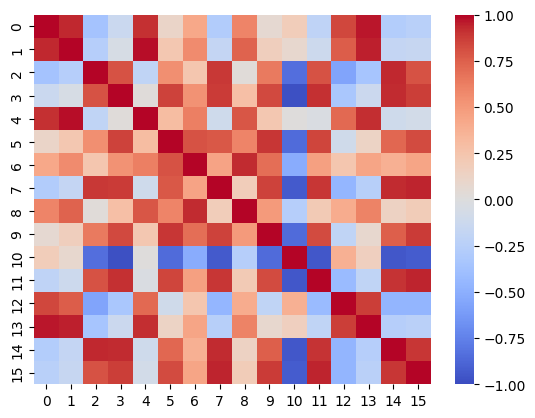

In [7]:
corr_matrix = np.corrcoef(layer_output.detach().cpu().numpy()[:,0,:], rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# 绘制相关性热图
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

## 绘制模型预测结果

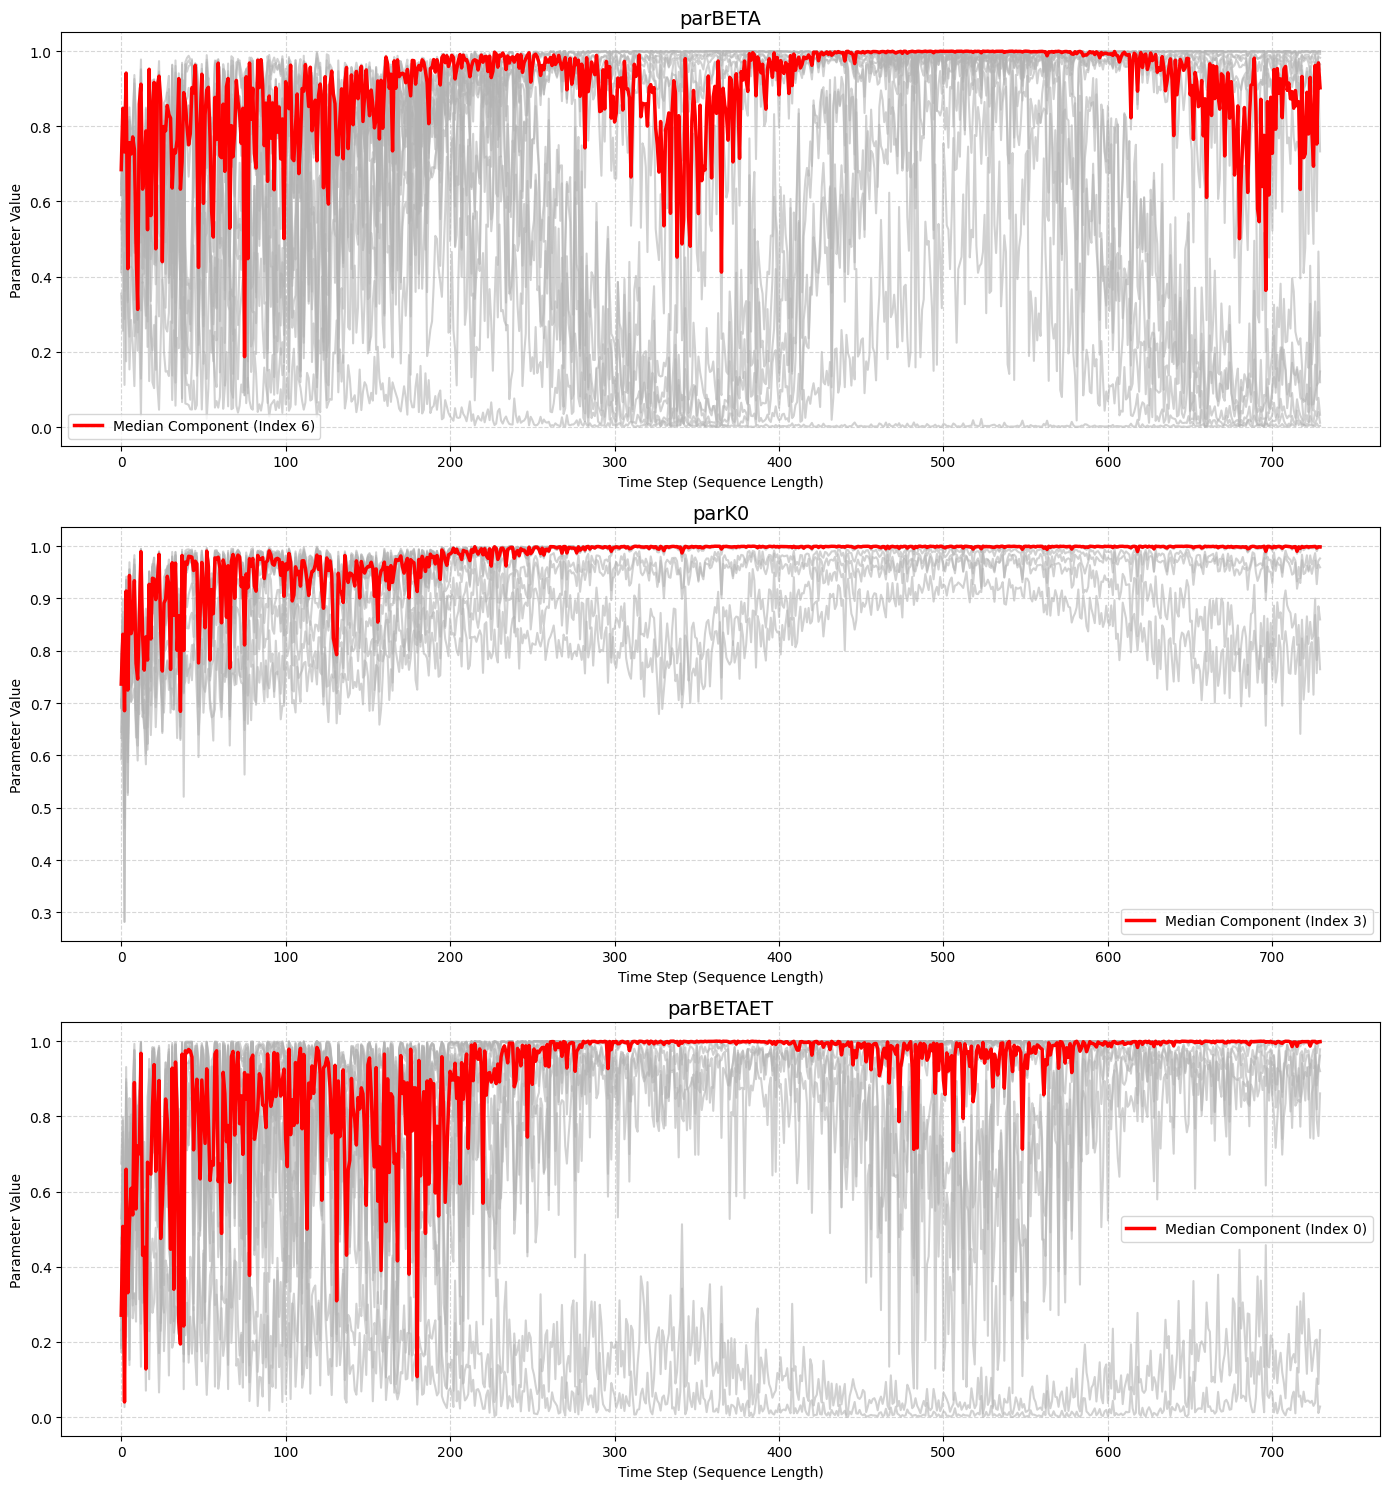

In [8]:
timevar_params = layer_output.detach().cpu().numpy()
titles = ['parBETA', 'parK0', 'parBETAET']
plot_parameters(timevar_params, titles=titles, median_color='red', smooth_window=1)
plt.show()

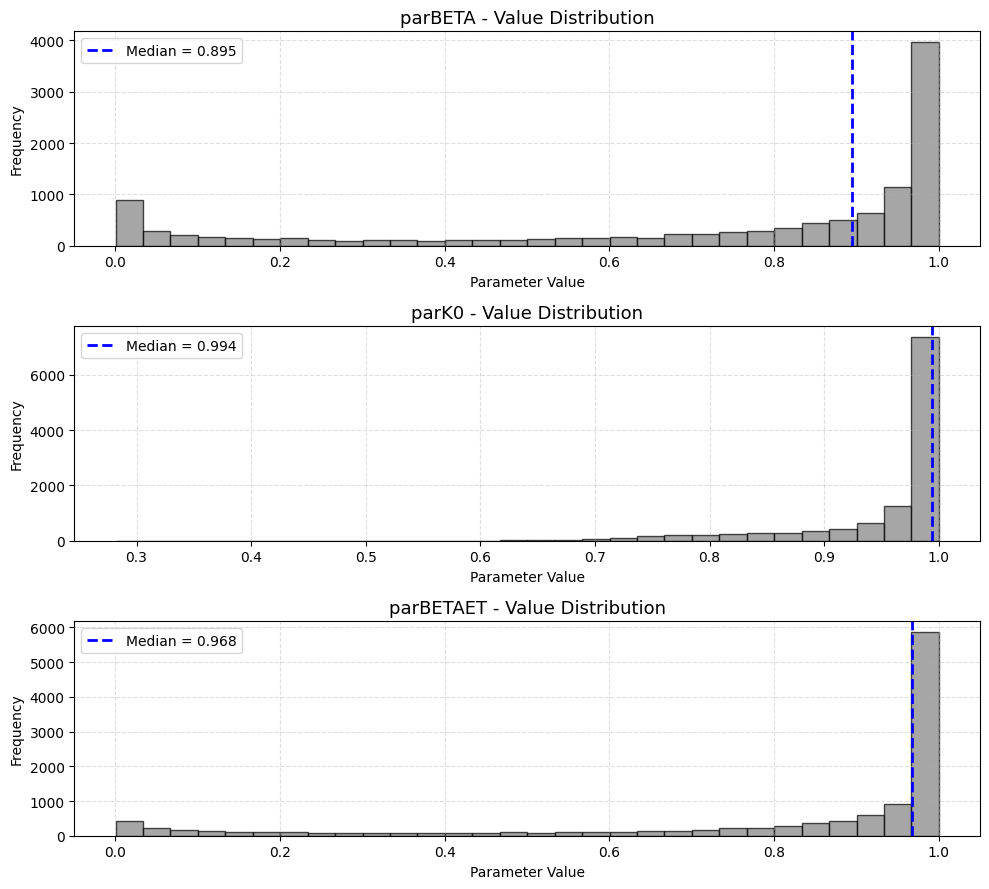

In [9]:
plot_parameter_distributions(timevar_params, titles=titles)
plt.show()